In [7]:
import numpy as np
import matplotlib.pyplot as plt
from data import generate_data_second_order 
from models import GibbsSamplerLLFM
from evals import latent_features, latent_features_dominant_to_file
import matplotlib.pyplot as plt


In [8]:
#Parameters
K=10            
alpha=1.5
sigma_w=3.0
sigma_b=0.5
mu_b=-15.0
n_iter=1000
burn=200
n_subsample=500
ax_values = [0, 6, 10, 15, 20, 30, 45, 60]
conds_list = [[1,0,0], [0,1,0], [0,0,1], [0,1,1]]
n_cond_gibbs = 50


In [9]:
posterior_probs_all = {str(conds): [] for conds in conds_list}
avg_features_list = []
dominant_features_list = []
for axnum in ax_values:

    # Generate dataset
    Data = generate_data_second_order(axnum=axnum)
    
    # Run Gibbs sampler
    sampler = GibbsSamplerLLFM(Data, K=K, n_iter=n_iter, alpha=alpha, sigma_w=sigma_w, sigma_b=sigma_b, mu_b=mu_b, burn=burn, n_subsample=n_subsample)
    sampler.run(verbose=False)
    sampler.get_posterior_samples()
    
    avg_features = latent_features(threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b)
    avg_features_list.append(avg_features)
    dominant_features = latent_features_dominant_to_file('latent_features_dominant.txt', threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b, header=f'Number of A-X pairs: {axnum}.\n\n')
    dominant_features_list.append(dominant_features)

    # ---- Posterior predictive probabilities ----
    for conds in conds_list:
        p_y3 = sampler.posterior_predictive(
            cond_obs=conds, n_z_samples=n_cond_gibbs
        )
        posterior_probs_all[str(conds)].append(p_y3)

Posterior grouping by number of active features

Number of samples with zero active features: 0/500

Group with 3 active features:
  Number of posterior samples: 1/500
  Average weights:
[[  2.43874682 -57.8470389  -52.1033172    2.74007472]
 [ -1.27241784 -26.4854482    2.86115559   1.0025945 ]
 [  0.09805243 -33.8831104  -27.65565386  -1.72655227]]
  Average bias:
[ -1.66751964 -13.69041615 -11.93248759  -1.91972487]
----------------------------------------
Group with 4 active features:
  Number of posterior samples: 2/500
  Average weights:
[[  3.02693715 -58.58636278 -52.80523943   2.28742119]
 [  1.0708261  -22.07339732 -15.80510557  -0.5679373 ]
 [  0.07736     -5.52676617   4.74586864   3.517428  ]
 [ -0.32096494 -14.10493465   1.32017436   1.01438952]]
  Average bias:
[ -2.29583923 -14.12639995 -12.14839748  -1.54806095]
----------------------------------------
Group with 5 active features:
  Number of posterior samples: 43/500
  Average weights:
[[  2.16961355 -55.49951951 -48

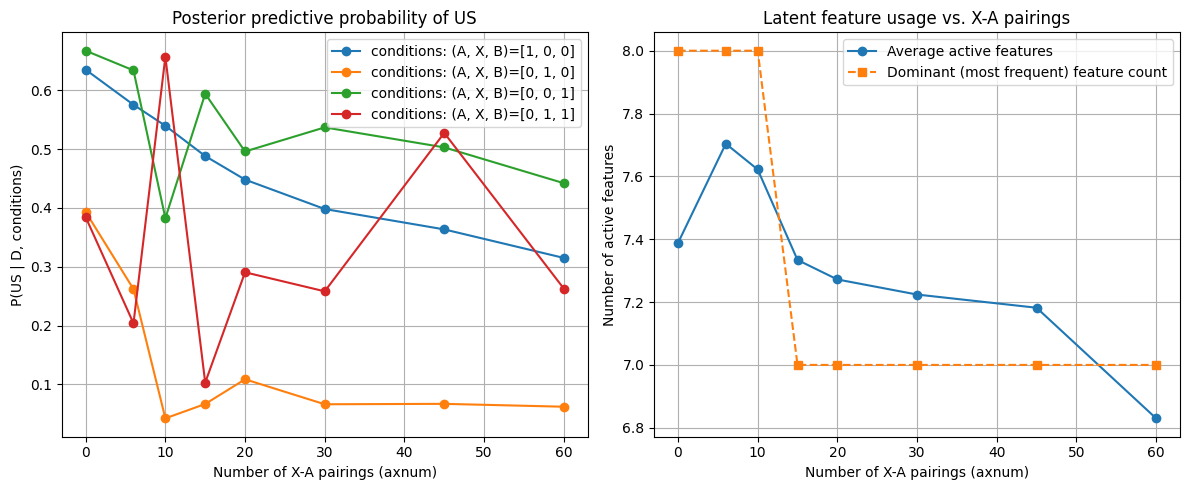

In [10]:
# ------------------------------
# Plot results
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ------------------------------
# Posterior predictive probabilities
# ------------------------------
for conds in conds_list:
    axes[0].plot(
        ax_values,
        posterior_probs_all[str(conds)],
        marker='o',
        label=f'conditions: (A, X, B)={conds}'
    )

axes[0].set_xlabel("Number of X-A pairings (axnum)")
axes[0].set_ylabel("P(US | D, conditions)")
axes[0].set_title("Posterior predictive probability of US")
axes[0].grid(True)
axes[0].legend()


# ------------------------------
# Latent feature statistics
# ------------------------------
axes[1].plot(
    ax_values,
    avg_features_list,
    marker='o',
    label="Average active features"
)

axes[1].plot(
    ax_values,
    dominant_features_list,
    marker='s',
    linestyle='--',
    label="Dominant (most frequent) feature count"
)

axes[1].set_xlabel("Number of X-A pairings (axnum)")
axes[1].set_ylabel("Number of active features")
axes[1].set_title("Latent feature usage vs. X-A pairings")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.savefig("posterior_predictive_and_features.png", dpi=300)
plt.show()
